In [1]:
import glob
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import math
from tqdm.auto import tqdm
from sklearn import linear_model
import optuna
import seaborn as sns

In [2]:
FEAT_OOFS = [
    {
        'model' : 'feat_lasso', 
         'fn' : '../output/2021011_segmentation_feature_model_v4/feature_model_oofs_0.csv'
    },
    {
        'model' : 'feat_linreg', 
        'fn' : '../output/2021011_segmentation_feature_model_v4/feature_model_oofs_1.csv'
    },
    {
        'model' : 'feat_ridge',
        'fn' : '../output/2021011_segmentation_feature_model_v4/feature_model_oofs_2.csv',
    }
]

CNN_OOFS = [
    {
        'model' : 'resnet50_rocstar',
        'fn' : '../output/resnet50_bs32_ep10_rocstar_lr0.0001_ps0.8_ranger_sz256/'
    },
    {
        'model' : 'resnet50_bce',
        'fn' : '../output/resnet50_bs32_ep10_bce_lr0.0001_ps0.8_ranger_sz256/'
    },
    {
        'model' : 'densenet169_rocstar',
        'fn' : '../output/densenet169_bs32_ep10_rocstar_lr0.0001_ps0.8_ranger_sz256/'
    },
    {
        'model' : 'resnet101_rocstar',
        'fn' : '../output/resnet101_bs32_ep20_rocstar_lr0.0001_ps0.8_ranger_sz256/'
    },
    {
        'model' : 'efficientnetv2_l_rocstar',
        'fn' : '../output/tf_efficientnetv2_l_bs32_ep10_rocstar_lr0.0001_ps0.8_ranger_sz256/'
    },
]

In [3]:
df = pd.read_csv('../output/20210925_segmentation_feature_model_v3/feature_model_oofs_0.csv')[
    ['BraTS21ID','MGMT_value','fold']]
df.head()

,BraTS21ID,MGMT_value,fold
0,0,1,2
1,2,1,2
2,3,0,1
3,5,1,2
4,6,1,0


In [49]:
def read_feat_oof(fn):
    return pd.read_csv(fn).sort_values('BraTS21ID')['oof_pred'].values

def read_cnn_oof(dir_path):
    oof_fns = [os.path.join(dir_path, f'fold-{i}', 'oof.csv') for i in range(5)]
    dfs = []
    for fn in oof_fns:
        dfs.append(pd.read_csv(fn))
    df = pd.concat(dfs)
    return df.sort_values('BraTS21ID')['pred_mgmt_tta'].values

def normalize_pred_distribution(preds, min_percentile=10, max_percentile=90):
    """ Clips min and max percentiles and Z-score normalizes """
    min_range = np.percentile(preds, min_percentile)
    max_range = np.percentile(preds, max_percentile)
    norm_preds = np.clip(preds, min_range, max_range)
    pred_std = np.std(norm_preds)
    pred_mean = np.mean(norm_preds)
    norm_preds = (norm_preds - pred_mean) / (pred_std + 1e-6)
    return norm_preds

def rescale_pred_distribution(preds):
    """ Rescales pred distribution to 0-1 range. Doesn't affect AUC """
    return (preds - np.min(preds)) / (np.max(preds) - np.min(preds) + 1e-6)

In [50]:
for d in FEAT_OOFS:
    df[d['model']] = read_feat_oof(d['fn'])
for d in CNN_OOFS:
    df[d['model']] = read_cnn_oof(d['fn'])
    
df_norm = df.copy()
for feat in df.columns.to_list()[3:]:
    df_norm[feat] = rescale_pred_distribution(
        normalize_pred_distribution(df_norm[feat].values)
    )
    
df_norm.head()

,BraTS21ID,MGMT_value,fold,feat_lasso,feat_linreg,feat_ridge,resnet50_rocstar,resnet50_bce,densenet169_rocstar,resnet101_rocstar,efficientnetv2_l_rocstar
0,0,1,2,0.400238,0.859248,0.066722,0.995366,0.918893,0.352219,0.944861,0.968443
1,2,1,2,0.681400,0.697969,0.736483,0.962248,0.364326,0.507380,0.939596,0.400794
2,3,0,1,1.000000,0.976026,1.000000,1.000000,0.294317,1.000000,0.420845,0.791184
3,5,1,2,0.843618,0.711901,0.915355,0.893415,0.697545,0.308397,0.949068,0.510978
4,6,1,0,0.584165,0.754715,0.363847,0.838764,1.000000,0.691758,1.000000,0.258448


In [51]:
df_raw = df.copy()

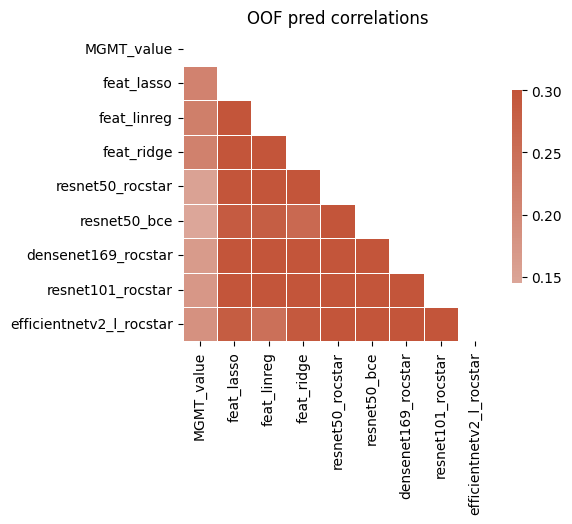

In [52]:
all_feat_names = df_norm.columns.to_list()[3:]
corr = df_norm[['MGMT_value'] + all_feat_names].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.close('all')
f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('OOF pred correlations')
plt.show()

In [53]:
mgmt_corr_sorted = corr['MGMT_value'].sort_values()
mgmt_corr_sorted 

resnet50_bce                0.145234
resnet50_rocstar            0.152105
densenet169_rocstar         0.165600
resnet101_rocstar           0.171292
efficientnetv2_l_rocstar    0.182996
feat_lasso                  0.211575
feat_ridge                  0.213856
feat_linreg                 0.219518
MGMT_value                  1.000000
Name: MGMT_value, dtype: float64

## Average

In [54]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

In [55]:
oof_preds = np.mean(df_norm[all_feat_names].to_numpy(),1)
oof_gts = df_norm['MGMT_value']

cv_preds = [np.mean(df_norm[df_norm.fold==fold][all_feat_names].to_numpy(),1) for fold in range(5)]
cv_gts = [df_norm[df_norm.fold==fold]['MGMT_value'] for fold in range(5)]

OOF acc 0.6065857885615251, OOF auc 0.6479849776108624, CV AUC 0.6484203763469425 (std 0.029397573539242678)


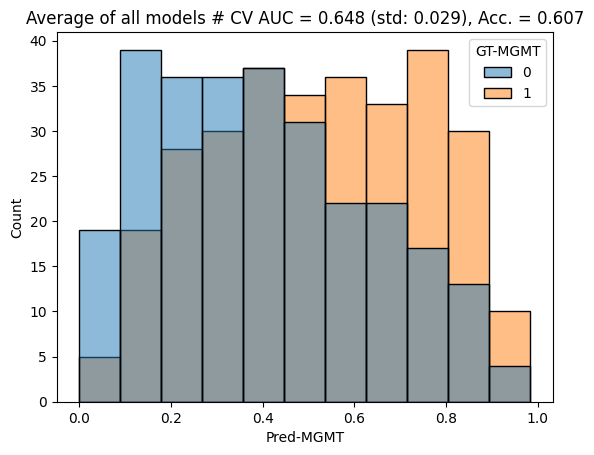

In [56]:
oof_acc = accuracy_score((np.array(oof_gts) > 0.5).flatten(), (np.array(oof_preds) > 0.5).flatten())
oof_auc = roc_auc_score(np.array(oof_gts).flatten().astype(np.float32), np.array(oof_preds).flatten())

cv_accs = np.array([accuracy_score((np.array(cv_gt) > 0.5).flatten(), (np.array(cv_pred) > 0.5).flatten())
        for cv_gt,cv_pred in zip(cv_gts, cv_preds)])
cv_aucs = np.array([roc_auc_score(np.array(cv_gt).flatten().astype(np.float32), np.array(cv_pred).flatten())
          for cv_gt,cv_pred in zip(cv_gts, cv_preds)])
print(f'OOF acc {oof_acc}, OOF auc {oof_auc}, CV AUC {np.mean(cv_aucs)} (std {np.std(cv_aucs)})')

plt.close('all')
df_plot = pd.DataFrame({'Pred-MGMT': oof_preds, 'GT-MGMT': oof_gts})
sns.histplot(x='Pred-MGMT', hue='GT-MGMT', data=df_plot)
plt.title(f'Average of all models # CV AUC = {np.mean(cv_aucs):.3f} (std: {np.std(cv_aucs):.3f}), Acc. = {np.mean(cv_accs):.3f}')
plt.show()

OOF acc 0.5944540727902946, OOF auc 0.6514516827964754, CV AUC 0.6504285580435163 (std 0.02232524533384981)


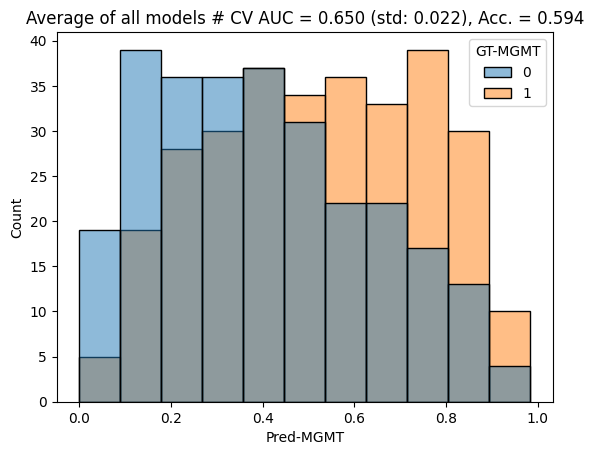

In [58]:
selected_feats = [
    'feat_lasso',
    'feat_ridge',
    'feat_linreg',
    'efficientnetv2_l_rocstar',
    'resnet101_rocstar',
    'densenet169_rocstar',
] 
oof_acc = accuracy_score((np.array(oof_gts) > 0.5).flatten(), (np.mean(df_norm[selected_feats].to_numpy(),1) > 0.5).flatten())
oof_auc = roc_auc_score(np.array(oof_gts).flatten().astype(np.float32), np.mean(df_norm[selected_feats].to_numpy(),1).flatten())

cv_preds = [np.mean(df_norm[df_norm.fold==fold][selected_feats].to_numpy(),1) for fold in range(5)]
cv_gts = [df_norm[df_norm.fold==fold]['MGMT_value'] for fold in range(5)]

cv_accs = np.array([accuracy_score((np.array(cv_gt) > 0.5).flatten(), (np.array(cv_pred) > 0.5).flatten())
        for cv_gt,cv_pred in zip(cv_gts, cv_preds)])
cv_aucs = np.array([roc_auc_score(np.array(cv_gt).flatten().astype(np.float32), np.array(cv_pred).flatten())
          for cv_gt,cv_pred in zip(cv_gts, cv_preds)])
print(f'OOF acc {oof_acc}, OOF auc {oof_auc}, CV AUC {np.mean(cv_aucs)} (std {np.std(cv_aucs)})')

plt.close('all')
df_plot = pd.DataFrame({'Pred-MGMT': oof_preds, 'GT-MGMT': oof_gts})
sns.histplot(x='Pred-MGMT', hue='GT-MGMT', data=df_plot)
plt.title(f'Average of all models # CV AUC = {np.mean(cv_aucs):.3f} (std: {np.std(cv_aucs):.3f}), Acc. = {np.mean(cv_accs):.3f}')
plt.show()

## 2nd level models

In [13]:
import xgboost as xgb
def get_data(fold, features):
    df = df_norm.dropna(inplace=False)
    scaler = StandardScaler()
    
    df_train = df[df.fold != fold]
    df_val = df[df.fold == fold]
    if len(df_val) == 0:
        df_val = df[df.fold == 0]
    
    # shuffle train
    df_train = df_train.sample(frac=1)
    
    y_train = df_train.MGMT_value.to_numpy().reshape((-1,1)).astype(np.float32)
    y_val = df_val.MGMT_value.to_numpy().reshape((-1,1)).astype(np.float32)
    
    X_train = df_train[features].to_numpy().astype(np.float32)
    X_val = df_val[features].to_numpy().astype(np.float32)
    
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    
    return X_train, y_train, X_val, y_val, scaler, (df_train.index.values).flatten(), (df_val.index.values).flatten()

def measure_cv_score(parameters, verbose=False, train_one_model=False, plot=False, return_oof_preds=False):
    
    val_preds = []
    val_gts = []
    val_aucs = []
    val_accs = []
    val_index_values = []
    
    for fold in range(5):
        
        if train_one_model: fold = -1
        
        X_train, y_train, X_val, y_val, scaler, train_index, val_index = get_data(fold, features=parameters['features'])
        val_index_values = val_index_values + list(val_index)
        
        if parameters['model_type'] == 'xgb':
            model = xgb.XGBRegressor(
                    n_estimators=parameters['n_estimators'], 
                    max_depth=parameters['max_depth'], 
                    eta=parameters['eta'],
                    subsample=parameters['subsample'], 
                    colsample_bytree=parameters['colsample_bytree'],
                    gamma=parameters['gamma']
                )
        elif parameters['model_type'] == 'linreg':
            model = linear_model.LinearRegression()
        elif parameters['model_type'] == 'ridge':
            model = linear_model.Ridge(parameters['alpha'])
        elif parameters['model_type'] == 'bayesian':
            model = linear_model.BayesianRidge(
                n_iter = parameters['n_iter'],
                lambda_1 = parameters['lambda_1'],
                lambda_2 = parameters['lambda_2'],
                alpha_1 = parameters['alpha_1'],
                alpha_2 = parameters['alpha_2'],
            )
        elif parameters['model_type'] == 'logreg':
            model = linear_model.LogisticRegression()
        elif parameters['model_type'] == 'lassolarsic':
            model = linear_model.LassoLarsIC(
                max_iter = parameters['max_iter'],
                eps = parameters['eps']
            )
        elif parameters['model_type'] == 'perceptron':
            model = linear_model.Perceptron(
            )
        else:
            raise NotImplementedError
        
        model.fit(X_train, y_train.ravel())
        
        if train_one_model:
            return model, scaler
        
        val_pred = model.predict(X_val)
        val_preds += list(val_pred)
        val_gts += list(y_val)
        val_aucs.append(roc_auc_score(np.array(y_val).flatten().astype(np.float32), np.array(val_pred).flatten()))
        val_accs.append(accuracy_score((np.array(y_val) > 0.5).flatten(), (np.array(val_pred) > 0.5).flatten()))
    
    if return_oof_preds:
        return np.array(val_preds).flatten(), np.array(val_gts).flatten(), val_index_values
    
    oof_acc = accuracy_score((np.array(val_gts) > 0.5).flatten(), (np.array(val_preds) > 0.5).flatten())
    oof_auc = roc_auc_score(np.array(val_gts).flatten().astype(np.float32), np.array(val_preds).flatten())
    auc_std = np.std(np.array(val_aucs))
    
    if plot:
        df_plot = pd.DataFrame({'Pred-MGMT': np.array(val_preds).flatten(), 'GT-MGMT': np.array(val_gts).flatten()})
        sns.histplot(x='Pred-MGMT', hue='GT-MGMT', data=df_plot)
        plt.title(f'{parameters["model_type"]} # CV AUC = {oof_auc:.3f} (std {auc_std:.3f}), Acc. = {oof_acc:.3f}')
        plt.show()
    
    if verbose:
        print(f'CV AUC = {oof_auc} (std {auc_std}), Acc. = {oof_acc}, aucs: {val_aucs}, accs: {val_accs}')
    
    # optimize lower limit of the (2x std range around mean)
    # This way, we choose the model which ranks well and performs ~equally well on all folds
    return float(oof_auc) - auc_std

In [14]:
default_parameters = {
    'model_type': 'linreg',
    'n_estimators': 100,
    'max_depth' : 3,
    'eta': 0.1,
    'subsample': 0.7,
    'colsample_bytree' : 0.8,
    'gamma' : 1.0,
    'alpha' : 1.0,
    'n_iter':300,
    'lambda_1': 1e-6, # bayesian
    'lambda_2':1e-6, # bayesian
    'alpha_1': 1e-6, # bayesian
    'alpha_2': 1e-6, # bayesian
    'max_iter': 3, #lasso
    'eps': 1e-6, #lasso
    'features' : all_feat_names
}
measure_cv_score(default_parameters, verbose=True)

CV AUC = 0.641051567239636 (std 0.016097278839270306), Acc. = 0.6204506065857885, aucs: [0.624633431085044, 0.6205278592375366, 0.6519370460048426, 0.6627272727272727, 0.6347962382445141], accs: [0.5982905982905983, 0.6324786324786325, 0.6347826086956522, 0.6347826086956522, 0.6017699115044248]


0.6249542884003657

In [101]:
def feat_selection_linreg_objective(trial):
    kept_feats = []
    for i in range(len(all_feat_names)):
        var = trial.suggest_int(all_feat_names[i], 0,1)
        if var == 1:
            kept_feats.append(all_feat_names[i])
    parameters = default_parameters.copy()
    parameters['features'] = kept_feats
    
    return 1 - measure_cv_score(parameters, verbose=False)

if 1:
    study = optuna.create_study()
    study.optimize(feat_selection_linreg_objective, n_trials=20, show_progress_bar=True)
    print(study.best_value, study.best_params)

[I 2021-10-07 21:08:14,414] A new study created in memory with name: no-name-c2d87aba-cb1a-4541-b488-f59298802bec
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2021-10-07 21:08:14,480] Trial 0 finished with value: 0.4437007008916334 and parameters: {'feat_lasso': 0, 'feat_linreg': 0, 'feat_ridge': 0, 'resnet50_rocstar': 1, 'resnet50_bce': 1, 'densenet169_rocstar': 1, 'resnet101_rocstar': 1, 'efficientnetv2_l_rocstar': 0}. Best is trial 0 with value: 0.4437007008916334.
[I 2021-10-07 21:08:14,512] Trial 1 finished with value: 0.3676899279334441 and parameters: {'feat_lasso': 1, 'feat_linreg': 0, 'feat_ridge': 1, 'resnet50_rocstar': 0, 'resnet50_bce': 0, 'densenet169_rocstar': 0, 'resnet101_rocstar': 1, 'efficientnetv2_l_rocstar': 0}. Best is trial 1 with value: 0.3676899279334441.
[I 2021-10-07 21:08:14,554] Trial 2 finished with value: 0.3596247295017474 and parameters: {'feat_lasso': 1, 'feat_linreg': 1, 'feat_ridge': 1, 'resnet50_rocstar': 0, 'resnet50_bce': 1, 'densenet169_rocstar': 1, 'resnet101_rocstar': 0, 'efficientnetv2_l_rocstar': 1}. Best is trial 2 with value: 0.3596247295017474.
[I 2021-10-07 21:08:14,595] Trial 3 finished with

In [102]:
study.best_params

{'feat_lasso': 1,
 'feat_linreg': 1,
 'feat_ridge': 1,
 'resnet50_rocstar': 0,
 'resnet50_bce': 0,
 'densenet169_rocstar': 0,
 'resnet101_rocstar': 0,
 'efficientnetv2_l_rocstar': 1}

In [103]:
pruned_features = default_parameters.copy()
pruned_features['features'] = ['feat_lasso', 'feat_linreg', 'feat_ridge', 'efficientnetv2_l_rocstar']
measure_cv_score(pruned_features, verbose=True)

CV AUC = 0.6597934421493572 (std 0.016749474559017194), Acc. = 0.6117850953206239, aucs: [0.6425219941348974, 0.6577712609970675, 0.6770581113801454, 0.6754545454545454, 0.6357366771159875], accs: [0.6239316239316239, 0.6324786324786325, 0.6521739130434783, 0.6, 0.5486725663716814]


0.64304396759034

In [108]:
random.randint(0,1)

1